In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import src
from src.reload import deep_reload

In [85]:
a = [1, 2, 3]
b = a[:]
a[0] += 1
a, b

([2, 2, 3], [1, 2, 3])

In [88]:
a = {'a': 1, 'b': 2}
b = a.copy()
a['a'] += 1
a, b

({'a': 2, 'b': 2}, {'a': 1, 'b': 2})

In [3]:
# Generating random graph
deep_reload(src)

seed = np.random.randint(0, sys.maxsize)
seed = 758712061200539789
print(seed)

n_nodes = 100
n_chargers = 10
charger_probability = .9
charger_fields = ['length']
charger_amounts = [40]
n_targets = 5
s = 10

scale = (100, 100)
link_bounds = (1e-6, np.inf)
link_speeds = [35, 55, 90, 105]

minimum_path_probability = .9

graph = src.graph.random_graph(
    n_nodes,
    scale,
    s = s,
    link_bounds = link_bounds,
    link_speeds = link_speeds,
    seed = seed,
)

deep_reload(src)

fields = ['length', 'time']
limits = [40, np.inf]
weights = [1, .5]

objective = src.dijkstra.Objective(fields, limits, weights = weights)

deep_reload(src)

rng = np.random.default_rng(seed)

charger_nodes = rng.choice(graph.nodes, n_chargers, replace = False)

chargers = {
    n: src.dijkstra.Charger(n, charger_fields, charger_amounts, charger_probability) \
    for n in charger_nodes}


target_nodes = rng.choice(graph.nodes, n_targets, replace = False)
source_nodes = rng.choice(graph.nodes, (1, ), replace = False)

758712061200539789


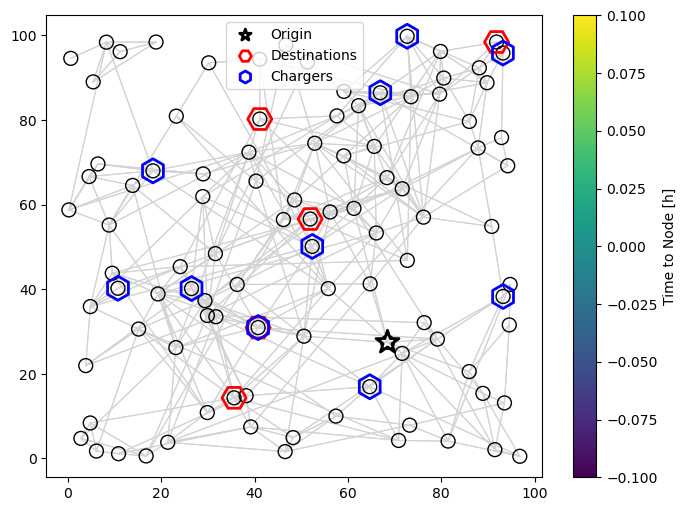

In [4]:
deep_reload(src)

fig = src.figures.dijkstra_output(
    graph, {}, source_nodes, target_nodes, chargers)

fig.savefig('Document/figs/random_graph.png', bbox_inches = 'tight', dpi = 300)

In [69]:
deep_reload(src)

path_values, _ = src.dijkstra.dijkstra(
    graph, source_nodes, objective,
    targets = target_nodes, chargers = chargers,
    minimum_path_probability = minimum_path_probability)

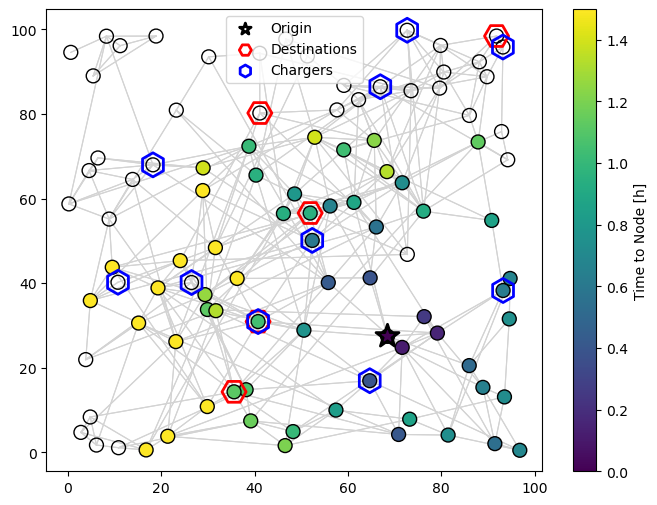

In [71]:
deep_reload(src)

fig = src.figures.dijkstra_output(
    graph, path_values, source_nodes, target_nodes, chargers)

fig.savefig('Document/figs/routing_with_chargers.png', bbox_inches = 'tight', dpi = 300)

In [73]:
deep_reload(src)

path_values, _ = src.dijkstra.dijkstra(
    graph, source_nodes, objective,
    targets = target_nodes, chargers = {},
    minimum_path_probability = minimum_path_probability)

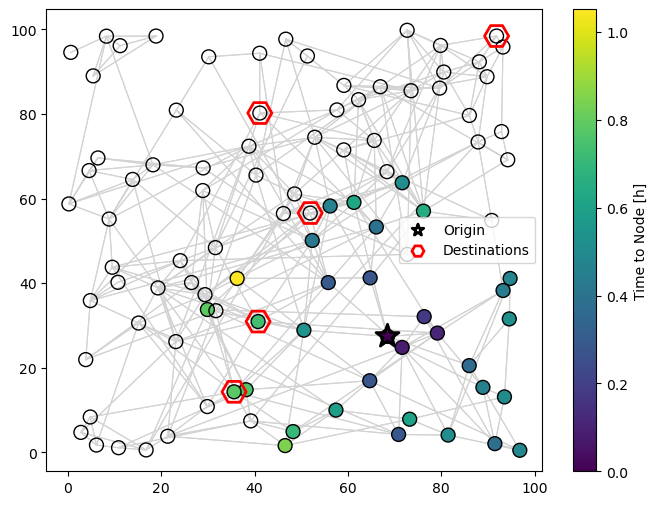

In [76]:
deep_reload(src)

fig = src.figures.dijkstra_output(
    graph, path_values, source_nodes, target_nodes, {})

fig.savefig('Document/figs/routing_without_chargers.png', bbox_inches = 'tight', dpi = 300)

In [89]:
path_values

{61: [0, 0],
 49: [4.089765874863979, 0.07435937954298144],
 80: [10.718163015196456, 0.10207774300187102],
 5: [12.75477020640162, 0.17063720544895522],
 72: [14.31255796088255, 0.2602283265615009],
 8: [14.592702732534292, 0.2653218678642598],
 94: [17.97434149645658, 0.5135526141844737],
 11: [18.827047932835402, 0.34230996241518913],
 78: [23.80251011325196, 0.43277291115003563],
 65: [24.627053767143963, 0.5520176117102504],
 40: [24.68280591679225, 0.2704835704184888],
 48: [26.123141280637515, 0.28420105007415797],
 20: [26.41094027455778, 0.37545101526316976],
 58: [27.029094312131345, 0.4914380784023881],
 55: [28.000363641941266, 0.6958439259205589],
 90: [28.019223274906953, 0.4166424749966073],
 7: [28.94277973437493, 0.4817278599226354],
 28: [31.24273749695063, 0.4524592996859815],
 84: [32.4587428795624, 0.5901589614465891],
 29: [32.80663102443073, 0.49763866343291496],
 64: [33.33795808913365, 0.44142261349722567],
 24: [33.782850405561646, 0.6142336437374845],
 69: [3

In [8]:
filename = 'Outputs/entity_atlas.json'

entities = src.graph.graph_from_json(filename)

In [21]:
entities._node['place_0'],entities._node['station_0']

({'status': 1,
  'visited': 0,
  'name': 'San Fernando',
  'class': 'C1',
  'geoid': '0666140',
  'x': -118.436242283817,
  'y': 34.28865249013806,
  'type': 'place',
  'type_num': 1},
 {'status': 1,
  'visited': 0,
  'x': -118.4898,
  'y': 34.010528,
  'n_dcfc': 2,
  'n_acl2': 12.0,
  'network': 'Non-Networked',
  'name': 'City of Santa Monica - Civic Parking Garage',
  'address': '333 Civic Center Dr',
  'city': 'Santa Monica',
  'state': 'CA',
  'zip': '90401',
  'access_code': 'public',
  'status_code': 'E',
  'type': 'station',
  'type_num': 0})

In [25]:
places = [k for k, n in entities._node.items() if n['type'] == 'place']
stations = [k for k, n in entities._node.items() if n['type'] == 'station']

places = src.graph.subgraph(entities, places)
stations = src.graph.subgraph(entities, stations)

In [28]:
gdf_zones = gpd.read_file('Data/NGOD/Shapes/V2_Zones.shp')

gdf_zones['in_california'] = gdf_zones['V2ZONEID'].apply(lambda zid: 'CA' in zid)

gdf_zones_california = gdf_zones[gdf_zones['in_california']]

gdf_zones_california = gdf_zones_california.explode(drop = True)

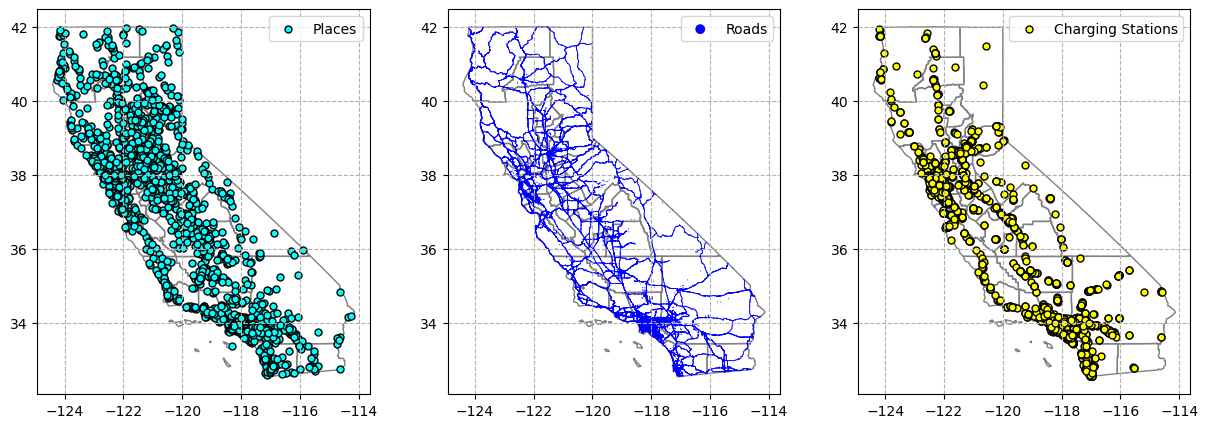

In [67]:
deep_reload(src)

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'cyan',
            'label': 'Places',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[0], ec = 'gray', fc = 'none')
src.figures.plot_graph(places, ax = ax[0], **kwargs)
ax[0].legend()
ax[0].grid(ls = '--')

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'b',
            'label': 'Roads',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[1], ec = 'gray', fc = 'none')
src.figures.plot_graph(atlas, ax = ax[1], **kwargs)
ax[1].legend(markerscale = 10)
ax[1].grid(ls = '--')

kwargs = {
		# 'node_field': 'type_num',
		'scatter': {
			's': 25,
			'ec': 'k',
            'fc': 'yellow',
            'label': 'Charging Stations',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax[2], ec = 'gray', fc = 'none')
src.figures.plot_graph(stations, ax = ax[2], **kwargs)
ax[2].legend()
ax[2].grid(ls = '--')

fig.savefig('Document/figs/California_Places_Chargers', bbox_inches = 'tight', dpi = 300)

In [43]:
places.number_of_nodes(),stations.number_of_nodes()

(1618, 1906)

In [47]:
atlas = src.graph.graph_from_json('Outputs/atlas.json')

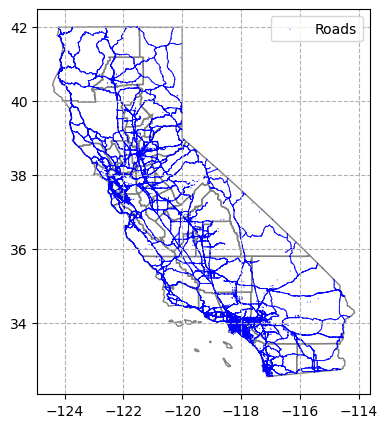

In [65]:
deep_reload(src)

fig, ax = plt.subplots(1, 1, figsize = (5, 5))

kwargs = {
		'node_field': None,
		'scatter': {
			's': .5,
			'ec': 'none',
            'fc': 'b',
            'label': 'Roads',
		},
		'show_links': False,
	}

gdf_zones_california.plot(ax = ax, ec = 'gray', fc = 'none')
src.figures.plot_graph(atlas, ax = ax, **kwargs)
ax.legend()
ax.grid(ls = '--')

# fig.savefig('Document/figs/California_Places_Chargers', bbox_inches = 'tight', dpi = 300)

In [68]:
4/5*1.5

1.2000000000000002

In [81]:
import time


t0 = time.time()
n = 10000

x_c = np.random.rand(n)
y_c = np.random.rand(n)

x_m = np.random.rand(n)
y_m = np.random.rand(n)

x0, x1 = np.meshgrid(x_c, x_m)
y0, y1 = np.meshgrid(y_c, y_m)

d2 = (x1-x0)**2 + (y1-y0)**2

print(time.time() - t0)

0.9956352710723877


In [82]:
np.argmin(d2, axis = 0)

array([5907, 7593, 8030, ..., 2189, 1521,  101])